In [49]:
import os
import numpy as np
import scipy

base_dir = r'./DataClassification/Split_dataset'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Valid')

# Directory with our training sclerosed pictures
train_scler_dir = os.path.join(train_dir, 'sclerosed')

# Directory with our training normal pictures
train_norm_dir = os.path.join(train_dir, 'normal')

# Directory with our validation sclerosed pictures
validation_scler_dir = os.path.join(validation_dir, 'sclerosed')

# Directory with our validation normal pictures
validation_norm_dir = os.path.join(validation_dir, 'normal')

In [50]:
train_scler_fnames = os.listdir(train_scler_dir)
print(train_scler_fnames[:10])

train_norm_fnames = os.listdir(train_norm_dir)
train_norm_fnames.sort()
print(train_norm_fnames[:10])

['SESCAM3_SCL_SESCAM_9_PAS_VUHSK_20_Aperio_5_1_90_21_270.png', 'LIT_NOR_VUHSK_135_PAS_VUHSK_20_Aperio_17_4_41_270_f.png', 'SESCAM2_NOR_caso6_1PAS_15_4_90_2.png', 'SESCAM2_SCL_caso12_6PAS_3_2_90_51.png', 'LIT_NOR_VUHSK_143_PAS_VUHSK_20_Aperio_2_4_90_22_f_270.png', 'SESCAM3_SCL_SESCAM_1_PAS_VUHSK_20_Aperio_10_3_90_2.png', 'SESCAM2_SCL_caso13_25927_PAS_11_4_fl_21_f.png', 'LIT_SCL_VUHSK_135_PAS_VUHSK_20_Aperio_3_4_90_4.png', 'LIT_NOR_VUHSK_135_PAS_VUHSK_20_Aperio_17_4_41_90_270.png', 'LIT_SCL_VUHSK_143_PAS_VUHSK_20_Aperio_1_1_flv_11_90_270.png']
['LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_0_flv_3.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_2_90_1.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_2_flv_2.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_3_3.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_3_fl_1.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_4_90_1.png', 'LIT_NOR_VUHSK_127_PAS_VUHSK_20_Aperio_10_4_90_2.png', 'LIT_NOR_VUHSK_127_PAS

In [51]:
print('total training sclerose images:', len(os.listdir(train_scler_dir)))
print('total training normal images:', len(os.listdir(train_norm_dir)))
print('total validation sclerose images:', len(os.listdir(validation_scler_dir)))
print('total validation normal images:', len(os.listdir(validation_norm_dir)))

total training sclerose images: 701
total training normal images: 623
total validation sclerose images: 214
total validation normal images: 142


In [52]:
batch_size = 20
epochs = 30
learning_rate = 0.001
dropout_rate = 0.5

In [53]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# The input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(dropout_rate)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=learning_rate),
              metrics=['acc'])

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,)


# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [55]:

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 1324 images belonging to 2 classes.
Found 356 images belonging to 2 classes.


In [56]:
history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=2)

Epoch 1/30


/tmp/ipykernel_12227/3540430446.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


67/67 - 3s - loss: 0.4739 - acc: 0.7885 - val_loss: 0.1672 - val_acc: 0.9242 - 3s/epoch - 41ms/step
Epoch 2/30
67/67 - 2s - loss: 0.2243 - acc: 0.9086 - val_loss: 0.1412 - val_acc: 0.9775 - 2s/epoch - 31ms/step
Epoch 3/30
67/67 - 2s - loss: 0.1591 - acc: 0.9388 - val_loss: 0.0500 - val_acc: 0.9888 - 2s/epoch - 30ms/step
Epoch 4/30
67/67 - 2s - loss: 0.1258 - acc: 0.9607 - val_loss: 0.1565 - val_acc: 0.9410 - 2s/epoch - 31ms/step
Epoch 5/30
67/67 - 2s - loss: 0.1018 - acc: 0.9675 - val_loss: 0.0887 - val_acc: 0.9635 - 2s/epoch - 30ms/step
Epoch 6/30
67/67 - 2s - loss: 0.0869 - acc: 0.9705 - val_loss: 0.1296 - val_acc: 0.9298 - 2s/epoch - 30ms/step
Epoch 7/30
67/67 - 2s - loss: 0.0691 - acc: 0.9743 - val_loss: 0.0306 - val_acc: 0.9916 - 2s/epoch - 30ms/step
Epoch 8/30
67/67 - 2s - loss: 0.0570 - acc: 0.9804 - val_loss: 0.0536 - val_acc: 0.9775 - 2s/epoch - 31ms/step
Epoch 9/30
67/67 - 2s - loss: 0.0450 - acc: 0.9849 - val_loss: 0.2326 - val_acc: 0.9242 - 2s/epoch - 31ms/step
Epoch 10/30


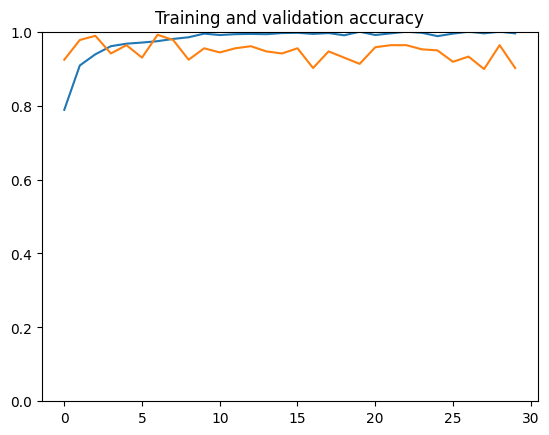

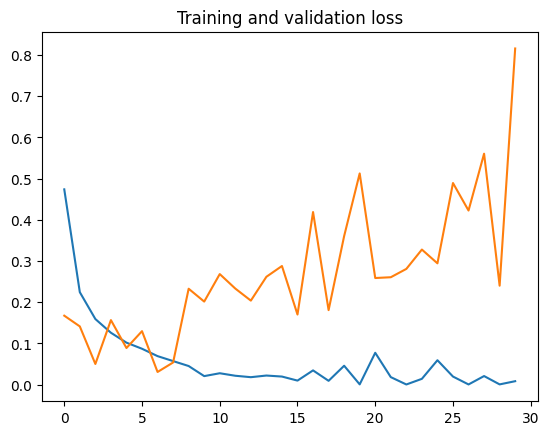

In [57]:
import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

plt.show()

In [58]:
# Save the model as a Keras model for ease of use later
model.save('./Models/CNN_model.keras')

In [59]:
from tensorflow.keras.preprocessing import image
import os

# Path to the test directory containing subdirectories "Normal" and "Sclerose"
test_dir = r'./DataClassification/Split_dataset/Test'

# List of classes
class_names = ['normal', 'sclerosed']

# Initializing counters for accuracy calculation
total_images = 0
correct_predictions = 0

# Loop through the test directories (Normal and Sclerose)
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        
        # Load the image and resize it to the expected size (150x150)
        img = image.load_img(img_path, target_size=(150, 150))
        
        # Convert the image to a numpy array
        img_array = image.img_to_array(img)
        
        # Expand the dimensions of the image to fit the expected batch size by the model
        img_array = np.expand_dims(img_array, axis=0)
        
        # Normalize pixel values to be in the range [0, 1]
        img_array = img_array / 255.0
        
        # Make predictions with the model
        prediction = model.predict(img_array, verbose=0)
        
        # Determine the true class of the image
        true_class = 1 if class_name == 'sclerosed' else 0
        
        # Calculate accuracy
        total_images += 1
        if (prediction > 0.5 and true_class == 1) or (prediction <= 0.5 and true_class == 0):
            correct_predictions += 1
        
        # Display prediction and true class for each image
        # print(f"Image {img_file} : Prediction : {class_names[int(prediction[0] > 0.5)]}, True Class : {class_name}")

# Calculate overall accuracy
accuracy = correct_predictions / total_images if total_images > 0 else 0
print(f"Test accuracy: {accuracy * 100:.2f}%")


Test accuracy: 97.73%


In [60]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras.models import load_model

# Load a model (Assuming a saved TensorFlow model)
model = load_model(f'./Models/CNN_model.keras')
# model.summary()

# Preprocess the image for the model (This needs to be adapted to your model's requirements)
def preprocess_image(img):
    img = img.resize((150, 150))  # Example for a model expecting 224x224 input
    img = tf_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Get the list of images
dir_list = os.listdir('./Classify')

images = []
sclerosed = []
normal = 0

# Process images by directory
for dir in dir_list:
    image_list = os.listdir(f'./Classify/{dir}')

    for image_name in image_list:
        images.append(image_name)

        # Load the image
        img = Image.open(f'./Classify/{dir}/{image_name}')

        # Preprocess the image
        img = preprocess_image(img)

        # Forward pass
        output = model.predict(img, verbose=0)

        # Get the predicted class by rounding the output probability
        predicted = np.round(output)

        if predicted:
            print(f'Image \t{image_name[24:-5]} \tof {dir} is predicted to be a sclerosed glomerulus')
            sclerosed.append(image_name)
        else:
            normal += 1

print(f"Total sclerosed: \t{len(sclerosed)}")

# # Save the list of sclerosed images as csv
import csv

with open(f'./Predictions/CNN_model_sclerosed.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Loop through the list of images
    for image in images:
        writer.writerow([image, 1 if image in sclerosed else 0])

Image 	PAS [123760, 50424, 540, 588] 	of C2330034-1-A-PAS is predicted to be a sclerosed glomerulus
Image 	PAS [75176, 21936, 688, 680] 	of C2326327-1-A-PAS is predicted to be a sclerosed glomerulus
Image 	PAS [166768, 39164, 564, 656] 	of C2326327-1-A-PAS is predicted to be a sclerosed glomerulus
Total sclerosed: 	3
